In [271]:
import numpy as np
import random
import scipy.linalg as la
import matplotlib.pylab as plt
import scipy.sparse as sps
from scipy.stats import poisson 
from numpy import random
import seaborn as sns
import pandas as pd

def network(N: int, p: float):

    ## GENERATE NETWORK
    # initialize adjacency matrix
    M = np.zeros((N,N), dtype = int)

    # % form edges
    for i in range (0, N-1):
        for j in range(i+1, N):

            #  form edge if uniform RV on [0,1] is no greater than formation probability p
            if random.uniform(0, 1) <= p:
                M[i,j] = 1
            #  form reverse edge
            M[j,i] = M[i,j]

    # initialize set of visited nodes
    visited = np.zeros((N,1))

######################################################################################################
    ## COMPUTE COMPONENTS C
    # initialize components
    C = {}
    c_index = 0
    #  cycle through nodes
    for n in range(0, N):
        # % if node has not been visited
        if visited[n] == 0:
            # flag node as visited
            visited[n] = 1
            # start new component and add current node as member
            members = [n]
            # initialize index
            index = 0
            while index <= len(members)-1:
                #  find unvisited neighbors of current node
                for i in range(0, N):
                    if (M[i,members[index]] == 1) and (visited[i] == 0):
                        #  add unvisited neighbors to member list
                        members.append(i)

                        #  flag visited neighbors as visited
                        visited[i] = 1
                            
                #  increment index
                index = index + 1
                
            #  store members of current component
            C[c_index] = members
            c_index = c_index + 1
######################################################################################################
    ##  COMPUTE DISTANCES

    #  % initialize distance matrix
    D = np.zeros((N,N), dtype = int)

    #  compute distances for each component
    Ncomps = len(C)
    for nc in range(0, Ncomps):

        #  get component
        comp = C[nc]
        Nc = len(comp)

        #  if component has more than one node

        if Nc > 1:
            #  get adjacency matrix for current component
            Mc = M[comp,:][:,comp]

            #  compute eigenvector decomposition of adjacency matrix
            Lam, V = la.eig(Mc)
            Vinv = np.linalg.inv(V)

            #  initialize distance matrix
            Dc = float("inf")*np.ones([Nc, Nc])

            #  set self distance to zero
            for i in range(0, Nc):
                Dc[i,i] = 0

            #  initialize path length
            k = 1
            Lam_k = np.eye(Nc)

            while Dc.max() == float("inf"):
                #  compute M^k
                Lam_k = np.diag(Lam**k)   
                Mck = V.dot(Lam_k).dot(Vinv)

                #  store path length for connected nodes
                for i in range(0, Nc-1):
                    for j in range(i+1, Nc):
                        if Mck[i,j] > 1E-3 and Dc[i,j] == float("inf"):
                            Dc[i,j] = k
                            Dc[j,i] = k

                # increment path length
                k = k+1

            #  store distances for current component
            for ii in range(0, len(comp)):
                for jj in range(0, len(comp)):
                    D[comp[ii],comp[jj]] = Dc[ii, jj]

    return M, C, D

In [325]:
N = 1000
p = 0.0001
M, C, D = network(N, p)

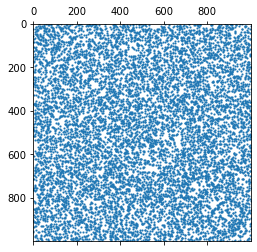

In [309]:
# Part 1): Plot density
plt.spy(sps.csr_matrix(M), precision=0.01, markersize=1)

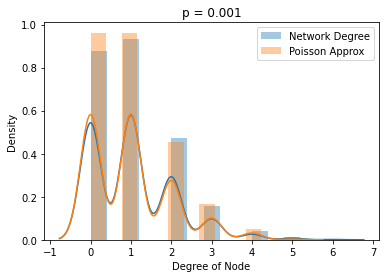

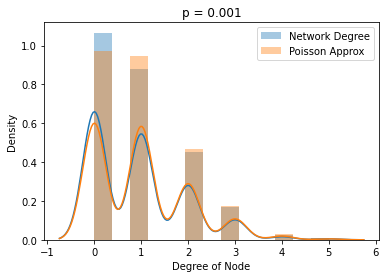

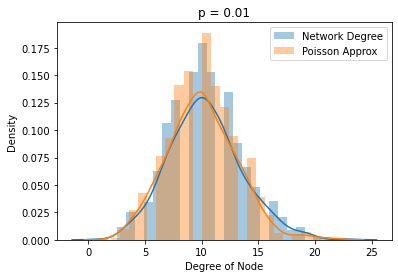

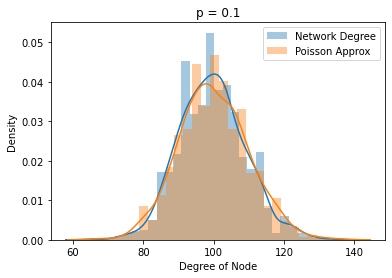

In [391]:
# Part 2): Degree distribution
N = 1000
p_list = [0.001, 0.001, 0.01, 0.1]    # List of values for p

for p in p_list:
    # Generate network
    M, C, D = network(N, p)
    # Compute degree of each node
    degree = np.zeros(N)
    for i in range(0, N):
        degree[i] = sum(M[i,:])

    # Plot density of network degree vs. Poisson approx
    plt.figure()
    sns.distplot(degree, hist = True, kde=True, label = 'Network Degree')
    sns.distplot(random.poisson(lam=(N-1)*p, size=1000), hist = True, kde=True, label = 'Poisson Approx')
    plt.legend(loc='upper right')
    plt.xlabel('Degree of Node')
    plt.title('p = ' +  str(p))

Text(0, 0.5, 'Size of the Largest Component')

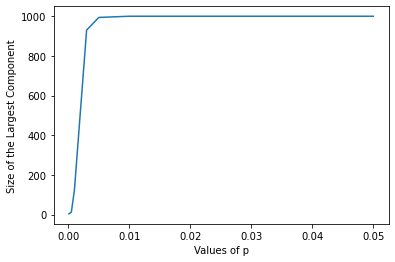

In [364]:
# Part 3: Connectedness
# Compute the size of network's largest component for different values of p
N = 1000
p_list = [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]    # List of values for p
giant_C = np.zeros(len(p_list))                           # Store the size of largest component in giant_C 
for i,p in enumerate(p_list):
    M, C, D = network(N, p)
    # Find the largest element of C and save in giant_C[i]
    for j in range(0, len(C)):
         if len(C[j])> giant_C[i]:
            giant_C[i] = len(C[j])
# Plot Phase Transition
plt.plot(p_list, giant_C)
plt.xlabel('Values of p')
plt.ylabel('Size of the Largest Component')

Text(0, 0.5, 'Average Distance of the Largest Component')

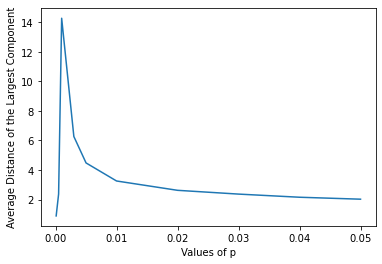

In [363]:
# Part 4: Distance
N = 1000
p_list = [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]    # List of values for p
avg_D = np.zeros(len(p_list))                           # Store the size of largest component in giant_C 
for i,p in enumerate(p_list):
    M, C, D = network(N, p)
    # Find the largest element of C and save index in i_c
    x = 0
    i_c = 0
    for j in range(0, len(C)):
         if len(C[j])> x:
            i_c = j               # Index i_c is the index of the largest compenent
            x = len(C[j])
    # Calculate average distance of component C[i_c]        
    avg_D[i] = D[C[i_c],:][:,C[i_c]].mean()
# Plot Phase Transition
plt.plot(p_list, avg_D)
plt.xlabel('Values of p')
plt.ylabel('Average Distance of the Largest Component')

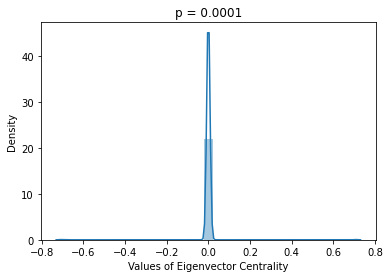

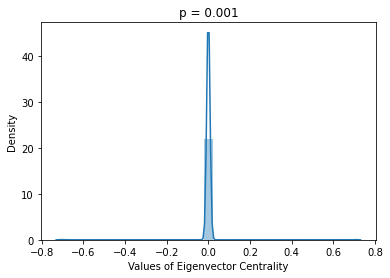

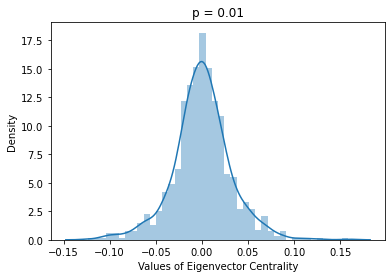

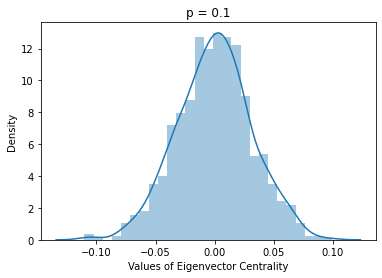

In [392]:
# Part 5: Eigenvector centrality
N = 1000
p_list = [0.0001, 0.001, 0.01, 0.1]    # List of values for p

for p in p_list:
    M, C, D = network(N, p)

    # Eigenvalues and Eigenvectors of M
    Lam, V = la.eig(M)

    # Find the index of the largest eigenvalues
    max_index = np.argmax(Lam)
    V_cen = V[:,index]

    # Plot distribution of eigenvector centrality
    plt.figure()
    sns.distplot(V_cen, hist = True, kde=True, label = 'Network Degree')
    plt.xlabel('Values of Eigenvector Centrality')
    plt.title('p = ' + str(p))